The following is a notebook to examine the distribution of protein interfaces manually selected between synaptic vesicle membranes.  Although this code could be applied to really any large set of 3D coordinates that one is trying find any patterns from.  This code uses PCA and DBSCAN to try to identify shapes that might be common between all of the distribution of 3d coordinates.   

In [2]:
import os
import xml.etree.ElementTree as ET
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.spatial.transform import Rotation as R
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


This part sets up the dataframe column and gets the file paths. 

In [3]:
pd.set_option('display.max_colwidth', -1)
point_contacts = []
dfcolumn_names = ['subtomogram', 'contact_num', 'nearest_neighbor', 'max distance', 'notes']
cmm_dataframe = pd.DataFrame(columns=dfcolumn_names)
file_path = '/Volumes/atbimac23-RAID/TomoPicking/coordpickernote.txt'


This parse_xml function gets the 3D coordinates from the cmm (XML file) and puts it into an numpy array. 

In [4]:
def parse_xml(file_path):
    """Extract 3D coordinates from XML file."""
    tree = ET.parse(file_path)
    root = tree.getroot()
    coords = []
    for marker in root.findall('.//marker'):
        x, y, z = float(marker.get('x')), float(marker.get('y')), float(marker.get('z'))
        coords.append([x, y, z])
    return np.array(coords)

Project_to_2d function performs a PCA dimensionality reduction to project the 3d coordinates onto a 2D plane. 

In [5]:
def project_to_2d(coords):
    """Project 3D points to a best-fit 2D plane using PCA."""
    if len(coords) == 1:
        return None # Ignore files with only one coordinate
    elif len(coords) == 2:
        point1, point2 = coords
        distance = np.linalg.norm(point2 - point1)
        return np.array([[0, 0], [distance, 0]])
    
    mean = np.mean(coords, axis=0)
    centered_coords = coords - mean
    pca = PCA(n_components=2)
    projected_coords = pca.fit_transform(centered_coords)
    return projected_coords

Iter_closest_pt aligns two sets of points together, the goal to try to align multiple interfaces to identify common shapes.  The translation limit is how much in pixel space(?) the cmm files are allowed to move. Rotation is also performed lower down.  One potential flaw of this is that if the first set is kinda crappy, everything is going to be aligned to that.  Probably need to do this a couple of times with random selection of points.  Or alternatively try a k-means clustering method. 

In [6]:
def iter_closest_pt(A, B, max_iteractions=500, tolerance=1e-6, translation_limit=20):
    """Aligns set A to set B using ICP."""
    A = np.copy(A).reshape(-1, 2)
    B = np.copy(B).reshape(-1, 2)
    prev_error = float('inf')
    
    for _ in range(max_iteractions):
        nbrs = NearestNeighbors(n_neighbors=1).fit(B)
        distances, indices = nbrs.kneighbors(A)
        
        distances = np.array(distances).reshape(-1, 1)
        indices = np.array(indices).reshape(-1, 1)
        
        mean_A = np.mean(A, axis=0)
        mean_B = np.mean(B[indices[:, 0]], axis=0)
        A_centered = A - mean_A
        B_centered = B[indices[:, 0]] - mean_B
        
        H = A_centered.T @ B_centered
        U, _, Vt = np.linalg.svd(H)
        R_optimal = Vt.T @ U.T
        
        if np.linalg.det(R_optimal) < 0:
            Vt[-1, :] *= -1
            R_optimal = Vt.T @ U.T
            
        A = (A- mean_A) @ R_optimal + np.clip(mean_B - mean_A, -translation_limit, translation_limit) + mean_A
        mean_error = np.mean(distances)
        
        if abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error
    
    return A

Iterative_mean_align function aligns all the sets to a computed mean shape.  Again this probably isn't great because it depends on the mean shape.  Something more like a clustering might be better.

In [431]:
def iterative_mean_align(coords_2d_list, max_iterations=500):
    """Align all the sets to a computed mean shape."""
    reference_set = max(coords_2d_list, key=len)
    #print(reference_set)
    for _ in range(max_iterations):
        aligned_sets = [iter_closest_pt(np.array(coords).reshape(-1, 2), reference_set) for coords in coords_2d_list]
        new_mean = np.mean(np.vstack(aligned_sets), axis=0).reshape(-1, 2)
        
        if np.allclose(reference_set, new_mean, atol=1e-6):
            break
        reference_set = new_mean
    return aligned_sets

Extract_shape_features attempts to address some of the problems of iterative_mean_align by extracting shapes from each interface. 

In [432]:
def extract_shape_features(coords_2d):
    """Extracts shape features for classification."""
    if len(coords_2d) == 1:
        return [0, 0, 0] #point
    elif len(coords_2d) == 2:
        return [1, 0, 0] #line
    
    #This computes PCA varience ratio
    pca = PCA(n_components=2)
    pca.fit(coords_2d)
    variance_ratio = pca.explained_variance_ratio_
    
    #This computes a convex hull
    hull = ConvexHull(coords_2d)
    num_hull_vertices = len(hull.vertices)
    
    #This computes the aspect ratio of a bounding box
    xmin, ymin = coords_2d.min(axis=0)
    xmax, ymax = coords_2d.max(axis=0)
    aspect_ratio = (xmax - xmin) / (ymax - ymin + 1e-6)
    
    return [variance_ratio[0], num_hull_vertices, aspect_ratio]

Next is an attempt to classify those shapes using DBSCAN clustering. 

In [433]:
def classify_shapes(all_coords_2d, eps=17):
    """Classify sets of points based on shape features."""
    shape_features = np.array([extract_shape_features(coords) for coords in all_coords_2d])
    
    # Cluster using DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=3).fit(shape_features)
    labels = clustering.labels_
    return labels

Detect_sub_clusters tries to do a finer shape search within each set of cmm coordinates again using DBSCAN

In [434]:
def detect_sub_clusters(coords_2d, eps=17, min_samples=3):
    """Detect sub-clusters within a single point could using DBSCAN"""
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords_2d)
    labels = clustering.labels_
    unique_labels = set(labels)
    sub_clusters = [coords_2d[labels == label] for label in unique_labels if label !=1]
    return sub_clusters, labels

Extract_subshape_features next tries to take the ouptu from the above DBSCAN subclusters and again search for shapes.

In [435]:
def extract_subshape_features(sub_clusters):
    """Extract shape features for each detected sub-cluster."""
    features = []
    for cluster in sub_clusters:
        if len(cluster) < 3:
            features.append([1, 0, 0]) #Line-like structure
        else:
            pca = PCA(n_components=2)
            pca.fit(cluster)
            variance_ratio = pca.explained_variance_ratio_
            hull = ConvexHull(cluster)
            num_hull_vertices = len(hull.vertices)
            xmin, ymin = cluster.min(axis=0)
            xmax, ymax = cluster.max(axis=0)
            aspect_ratio = (xmax - xmin) / (ymax -ymin + 1e-6)
            features.append([variance_ratio[0], num_hull_vertices, aspect_ratio])
    return features

Classify_subshapes then classifies the shapes as determined from the above.  So basically its again a finer search and clustering. 

In [436]:
def classify_subshapes(all_coords_2d):
    """Classify sub-clusters found in each set of 2D coordinates."""
    all_subshape_features = []
    all_subshape_labels = []
    
    for coords_2d in all_coords_2d:
        sub_clusters, _ = detect_sub_clusters(coords_2d)
        features = extract_subshape_features(sub_clusters)
        all_subshape_features.exted(features)
        
    if all_subshape_features:
        clustering = DBSCAN(eps=4.0, min_samples=2).fit(all_subshape_features)
        all_subshape_labels = clustering.labels_
    
    return all_subshape_labels

The next seven cells are setting up diffent types of plots that one might want to use to vizualize everything. 

In [437]:
def plot_heatmap(all_coords_2d):
    """Generate a heatmap from projected 2D coordinates."""
    x, y = all_coords_2d[:, 0], all_coords_2d[:, 1]
    sns.kdeplot(x, y, cmap='coolwarm', fill=True)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("2D Projection Heatmap")

In [438]:
def plot_contour(all_coords_2d):
    """Generate a contour plot from projected 2D coordinates."""
    x, y = all_coords_2d[:, 0], all_coords_2d[:, 1]
    plt.figure(figsize=(10, 10))
    #perform kernel density estimation
    try:
        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()
        xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        kde = gaussian_kde(np.vstack([x, y]), bw_method=0.2)
        f = np.reshape(kde(positions), xx.shape)
        
        levels = np.linspace(f.min(), f.max(), 10) if f.max() > f.min() else [f.min()]
        plt.contourf(xx, yy, f, levels=levels, cmap='coolwarm')
        plt.colorbar(label="Density")
    except np.linalg.LinAlgError:
        print(f"KDE failed, using histogram-based contour instead.")
        plt.hist2d(x, y, bins=30, cmap='coolwarm')
        plt.colorbar(label="Density")
             
   
    plt.xlabel("Pix_X")
    plt.ylabel("Pix_Y")
    plt.title("2D Projection Contour Plot")

In [439]:
def plot_scatter(all_coords_2d):
    """Generate a scatter plot from projected 2D coordinates"""
    plt.figure(figsize=(8, 6))
    plt.scatter(all_coords_2d[:,0], all_coords_2d[:, 1], c='blue', alpha=0.5)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("2D projection Scatter Plot")

In [440]:
def plot_scatter_together(aligned_sets, point_size=10):
    """Generate a scatter plot from projected 2D coordinates with all subtomos together and different colors"""
    plt.figure(figsize=(10, 10))
    colors = sns.color_palette("husl", len(aligned_sets))
    
    for i, coords in enumerate(aligned_sets):
        plt.scatter(coords[:, 0], coords[:, 1], color=colors[i], alpha=0.6, label=f"Set {i+1}", s=point_size)
        #plt.scatter(coords[:, 0], coords[:, 1], color=colors[i], alpha=0.6, label=f"Set {i+1}")
    plt.xlabel("Pix_X")
    plt.ylabel("Pix_Y")
    plt.title("2D Projection Scatter Plot (All Sets)")

In [441]:
def plot_classified_shapes(aligned_sets, shape_labels, draw_boundaries=True):
    """plot classified shapes with different colors for each class."""
    plt.figure(figsize=(10,10))
    unique_labels = set(shape_labels)
    colors = sns.color_palette("husl", len(unique_labels))
    colormap = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    for i, (coords, label) in enumerate(zip(aligned_sets, shape_labels)):
        if draw_boundaries and len(coords) > 2:
            hull = ConvexHull(coords)
            for simplex in hull.simplices:
                plt.plot(coords[simplex, 0], coords[simplex, 1], color=colormap[label], alpha=0.6, linewidth=1.5)
        plt.scatter(coords[:, 0], coords[:, 1], color=colormap[label], alpha=0.7, label=f"Class {label}" if label not in colormap else "")
    
    plt.xlabel("Pix_X")
    plt.ylabel("Pix_Y")
    plt.title("Classified 2D Projected Shapes")
    plt.legend()

In [580]:
def plot_knn_distance(coords_2d, k=2, plot_type="histogram"):
    """Plot k-nearest neighbors distance to determine optimal eps for DBSCAN."""
    distances = []
    for coords in coords_2d:
        if len(coords_2d) > k:
            nbrs = NearestNeighbors(n_neighbors=k).fit(coords_2d)
            dists, _ = nbrs.kneighbors(coords_2d)
            dists = np.sort(dists[:, k-1])
            distances.extend(dists)
    
    distances = np.sort(distances)
    #plt.figure(figsize=(10,10))
    #if plot_type == "line":
    #    plt.plot(distances, marker="o", linestyle="-", color="b")
    #    plt.xlabel("Points sorted by distance")
    #    plt.ylabel(f"{k}-Nearest Neighbor Distance")
    #    plt.title("k-NN Distance Plot for Optimal eps Selection")
    #elif plot_type == "histogram":
    #    plt.hist(distances, bins=50, color="b", alpha=0.7)
    #    plt.xlabel(f"{k}-Nearest Neighbor Distance")
    #    plt.ylabel("Frequency")
    #    plt.title("k-NN Distance Histogram for Optimal eps Selection")
    #plt.grid()
    
    #print(distances)
    return distances

In [ ]:
def plot_subcluster_shapes(aligned_sets, eps=17, min_samples=3):
    """Plot sub-clusters within each classified shape."""
    plt.figure(figsize=(10, 10))
    colors = sns.color_palette("husl", 10)
    
    for coords in aligned_sets:
        sub_clusters, labels = detect_sub_clusters(coords, eps, min_samples)
        for i, cluster in enumerate(sub_clusters):
            plt.scatter(cluster[:, 0], cluster[:, 1], color=colors[i % len(colors)], alpha=0.7, label=f"Subcluster {i}")
            if len(cluster) > 2:
                hull = ConvexHull(cluster)
                for simplex in hull.simplices:
                    plt.plot(cluster[simplex, 0], cluster[simplex, 1], color=colors[i % len(colors)], linewidth=1.5)
                    
    plt.xlabel("Pix_X")
    plt.ylabel("Pix_Y")
    plt.title("Detected Sub-Clusters in Shapes")
    plt.legend()   

Okay now we get to the actual processing of a directory.  This will run through all the cmm files within a given directory. It also sets up a pandas dataframe that will capture all the information that is being used so that user can backtack a bit and choose which cmm files they might want to use as "exemplary".

In [624]:
def process_directory(input_dir):
    """Process all XML files in the input directory and save visualizations"""
    #if not os.path.exists(ouput_dir):
    #    os.makedirs(output_dir)
    
    all_coords_2d = []
    data_df = pd.DataFrame(columns=['file_path', 'coords_3d', 'coords_2d', 'nearest_neighbor', 'farthest_neighbor', 'notes'])
    
    for root_dir, subfolder, files in os.walk(input_dir):
        for filename in files:
            if filename.endswith(".cmm"):
                file_path = os.path.join(root_dir, filename)
                coords_3d = parse_xml(file_path)
                coords_2d = project_to_2d(coords_3d)
                
                
                if coords_2d is None or len(coords_2d) < 2:
                    print(f"Skipping {file_path} due to insufficient coordinates")
                    continue
                
                if len(coords_2d) == 2:
                    distance = np.linalg.norm(np.array(coords_2d[0]) - np.array(coords_2d[1]))
                    nearest_neighbor = distance
                    farthest_neighbor = distance
                    print(f"Two coordinates for {file_path}: {nearest_neighbor}")
                
                else:
                    #all_coords_2d.append(coords_2d)
                    knn_distances = plot_knn_distance(coords_2d, k=2, plot_type="histogram")
                
                    if len(knn_distances) == 0:
                        print(f"skipping file {file_path} due to not enough points")
                        continue
                        
                    #print(f"knn_distances for {file_path}: {knn_distances}")
                    
                    nearest_neighbor = knn_distances[0]
                    farthest_neighbor = knn_distances[-1]
                    
                    #print(f"Adding data for {file_path}: {nearest_neighbor}, {farthest_neighbor}")
                
                data_df = data_df.append({
                    'file_path': file_path, 
                    'coords_3d': coords_3d, 
                    'coords_2d': coords_2d,
                    'nearest_neighbor': nearest_neighbor,
                    'farthest_neighbor': farthest_neighbor,
                    'notes': ''}, ignore_index=True)
                    #plot_scatter(coords_2d)
                    #print(coords_2d)
                
                #print("DataFrame after append:")
                #print(data_df.tail())
    print(data_df.columns)
    
    return data_df
                
    if all_coords_2d:
        aligned_sets = iterative_mean_align(all_coords_2d)
        all_coords_2d = np.vstack(aligned_sets)
        shape_labels = classify_shapes(aligned_sets)
        #plot_heatmap(all_coords_2d)
        #plot_scatter(all_coords_2d)
        plot_scatter_together(aligned_sets)
        plot_contour(all_coords_2d)
        #plot_classified_shapes(aligned_sets, shape_labels)
        plot_knn_distance(aligned_sets, k=2)
        #plot_subcluster_shapes(aligned_sets, eps=17)
        
    #return data_df

In [805]:
small_df = process_directory('TomoPicking/subcoord_files')

#process_directory('TomoPicking/cmm_files/2023_Tomo') # An example directory.

Two coordinates for TomoPicking/subcoord_files/20190920_MPI/T010/T010000005_filt.cmm: 22.039752720935862
Skipping TomoPicking/subcoord_files/201810XX_MPI/SV4_003_dff/SV4_003_dff000026_filt.cmm due to insufficient coordinates
Skipping TomoPicking/subcoord_files/201810XX_MPI/SV4_003_dff/SV4_003_dff000002_filt.cmm due to insufficient coordinates
Index(['file_path', 'coords_3d', 'coords_2d', 'nearest_neighbor',
       'farthest_neighbor', 'notes'],
      dtype='object')


In [630]:
print(small_df)

                                                                        file_path  \
0  TomoPicking/subcoord_files/20190920_MPI/T010/T010000005_filt.cmm                 
1  TomoPicking/subcoord_files/20191108_MPI/Tomo_089/Tomo_089000017_filt.cmm         
2  TomoPicking/subcoord_files/20191108_MPI/Tomo_089/Tomo_089000011_filt.cmm         
3  TomoPicking/subcoord_files/201810XX_MPI/SV5_001_dff/SV5_001_dff000020_filt.cmm   

                                                                                                                                                                               coords_3d  \
0  [[146.69, 150.53, 127.97], [139.3, 129.84, 126.22]]                                                                                                                                     
1  [[114.35, 115.15, 128.74], [105.36, 135.82, 126.99], [125.59, 94.441, 133.92], [119.98, 104.51, 136.23]]                                                                                
2  [[130.4

In [631]:
full_df = process_directory('TomoPicking/cmm_files/2023_Tomo')

Two coordinates for TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_002000006_filt.cmm: 16.566632126053868
Two coordinates for TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_049000003_filt.cmm: 36.670242704405425
Skipping TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_025000003_filt.cmm due to insufficient coordinates
Skipping TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_035000004_filt.cmm due to insufficient coordinates
Skipping TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_061000006_filt.cmm due to insufficient coordinates
Two coordinates for TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_027000004_filt.cmm: 14.639306677571879
Skipping TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_032000004_filt.cmm due to insufficient coordinates
Skipping TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_053000002_filt.cmm due to insufficient coordinates
Skipping TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_036000003_filt.cmm due to insufficient coordinates
Skipping Tomo

In [650]:
def Plot_perInterface_KNN(dataframe, binwidth):
    min_val = full_df['nearest_neighbor'].min()
    max_val = full_df['nearest_neighbor'].max()
    bins = np.arange(min_val, max_val + binwidth, binwidth)
    
    hist, bin_edges = np.histogram(dataframe['nearest_neighbor'], bins=bins)
    
    peak_index = np.argmax(hist)
    peak_value = bin_edges[peak_index]
    peak_frequency = hist[peak_index]
    
    print(f"The peak of the histogram is at bin range {peak_value}-{bin_edges[peak_index + 1]}")
    print(f"Peak frequency: {peak_frequency}")

    plt.figure(figsize=(10,10))
    plt.hist(dataframe['nearest_neighbor'], bins=bins, color='b', alpha=0.7)
    plt.xlabel('Nearest Neighbor Distance')
    plt.ylabel('Frequency')
    plt.title(f"Histogram of NearestNeighbor Distances (Bin width = {binwidth})")
    plt.grid(True)
    plt.show()


The peak of the histogram is at bin range 7.971676945967324-10.471676945967324
Peak frequency: 118


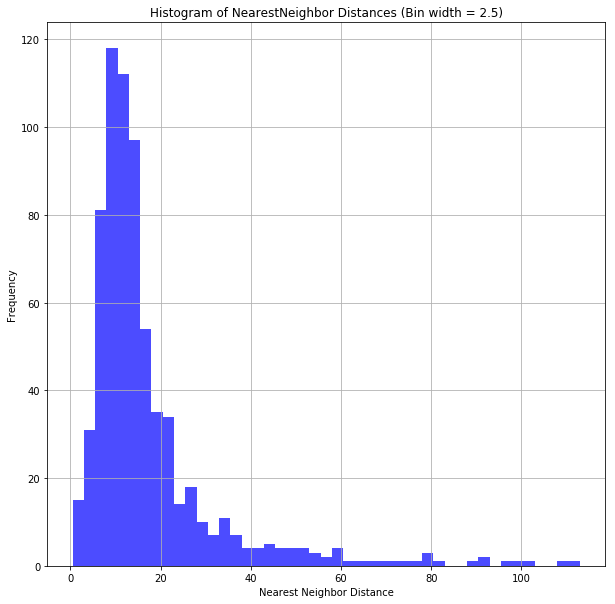

In [658]:
Plot_perInterface_KNN(full_df, 2.5)

Probably should simulate some data for comparison.  Given the average size of the interface, what would be the kNN distance given random distribution of increasing number of points. DO THIS SOON.

In [661]:
full_df

,file_path,coords_3d,coords_2d,nearest_neighbor,farthest_neighbor,notes
0,TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_002000007_filt.cmm,"[[145.15, 107.67, 118.08], [152.27, 114.94, 115.95], [132.34, 134.93, 115.5], [99.989, 165.21, 119.33], [120.0, 150.68, 118.47], [140.25, 158.13, 115.48], [125.38, 124.29, 116.17]]","[[-31.787591165407086, -5.415141130770838], [-30.129228483474755, 4.755738964896518], [-2.2730220706099, 0.4363641296663017], [41.3100629815429, -8.207002821846771], [17.793183842303506, -0.5185290933932588], [11.880091816477105, 20.413563430723144], [-6.793496920831754, -11.464993479275075]]",10.305191,24.741791,
1,TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_002000006_filt.cmm,"[[105.78, 112.93, 120.79], [104.97, 128.87, 116.35]]","[[0.0, 0.0], [16.566632126053868, 0.0]]",16.566632,16.566632,
2,TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_028000005_filt.cmm,"[[136.11, 112.68, 125.6], [141.24, 144.85, 120.44], [141.32, 136.79, 126.0]]","[[19.126528790356094, -0.7145058809427401], [-13.829201424898267, -2.045387535850838], [-5.297327365457821, 2.7598934167935796]]",9.792017,24.669743,
3,TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_049000003_filt.cmm,"[[130.47, 132.95, 137.02], [153.64, 105.02, 131.75]]","[[0.0, 0.0], [36.670242704405425, 0.0]]",36.670243,36.670243,
4,TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_015000001_filt.cmm,"[[111.6, 125.94, 138.08], [124.66, 134.52, 118.49], [129.42, 129.71, 113.81]]","[[18.337641506421207, -0.6123393973390527], [-6.405407262713211, 3.353721319321252], [-11.932234243708002, -2.741381921982198]]",8.227764,25.058893,
5,TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_027000004_filt.cmm,"[[107.51, 129.98, 132.3], [110.78, 135.4, 119.1]]","[[0.0, 0.0], [14.639306677571879, 0.0]]",14.639307,14.639307,
6,TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_046000003_filt.cmm,"[[138.69, 131.33, 120.06], [129.91, 138.06, 135.83], [139.56, 142.86, 121.08], [133.86, 120.75, 124.36]]","[[3.010097661237866, -5.702595264509514], [-6.9699561413186695, 10.7728912390766], [-8.461999236576814, -7.433226709284568], [12.421857716657614, 2.362930734717486]]",11.601900,18.267154,
7,TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_023000002_filt.cmm,"[[148.98, 121.74, 111.05], [111.93, 143.63, 115.97]]","[[0.0, 0.0], [43.313750703442885, 0.0]]",43.313751,43.313751,
8,TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_047000003_filt.cmm,"[[119.96, 140.31, 142.98], [126.84, 120.04, 141.7], [140.32, 145.04, 134.65]]","[[-0.9069890467551708, 10.89575675726614], [-14.169991364091956, -5.954717109373915], [15.076980410847122, -4.9410396478922225]]",21.444013,22.500920,
9,TomoPicking/cmm_files/2023_Tomo/20191105_MPI/Tomo_052000003_filt.cmm,"[[106.6, 128.08, 132.08], [123.43, 139.51, 136.88]]","[[0.0, 0.0], [20.90296151266609, 0.0]]",20.902962,20.902962,


Need to add the notes to the pandas data frame so that one can easily exclude some of the interfaces in which things were hypersampled. Also...probably shouldn't have hypersampled any of them, but oh well...

In [715]:
def Add_notes_to_dataframe(dataframe, notes_file):
    for index, row in dataframe.iterrows():
        file_path = row['file_path']
        parts = file_path.split('/')
        butt = parts[2]
    return butt
print(butt)

IndentationError: unexpected indent (<ipython-input-715-854d29207ed1>, line 2)

In [806]:
def add_notes_to_dataframe(data_df):
    notes_data = []
    with open('/Volumes/atbimac23-RAID/TomoPicking/coordpickernote.txt', 'r') as file:
        next(file)
        
        for line in file:
            note_parts = line.split()
            note_name = note_parts[0]
            note_path_parts = note_name.split('/')
            #print(note_path_parts)
            if len(note_path_parts) > 3:
                note_folder = note_path_parts[2]
            else:
                note_folder = ''
            #print(note_folder)
            note_file = note_path_parts[-1].split('.')[0]
            #print(note_parts)
            notes = ' '.join(note_parts[1:])
            notes_data.append([note_folder, note_file, notes])
    notes_df = pd.DataFrame(notes_data, columns = ['folder', 'file_name', 'notes'])
        
    for index, row in small_df.iterrows():
            file_path = row['file_path']
            parts = file_path.split('/')
            folder = parts[2]
            file_name = parts[-1].split('.')[0]
            
            print(f"matching {folder} and {file_name}")
        
            match = notes_df[(notes_df['folder'] == folder) & (notes_df['file_name'] == file_name)]
        
            if not match.empty:
                notes = match['notes'].values[0]
                data_df.at[index, 'notes'] = notes
            else:
                data_df.at[index, 'notes'] = ''
    return data_df    

In [807]:
add_notes_to_dataframe(small_df)

matching 20190920_MPI and T010000005_filt
matching 20191108_MPI and Tomo_089000017_filt
matching 20191108_MPI and Tomo_089000011_filt
matching 201810XX_MPI and SV5_001_dff000016_filt
matching 201810XX_MPI and SV5_001_dff000020_filt


,file_path,coords_3d,coords_2d,nearest_neighbor,farthest_neighbor,notes
0,TomoPicking/subcoord_files/20190920_MPI/T010/T010000005_filt.cmm,"[[146.69, 150.53, 127.97], [139.3, 129.84, 126.22]]","[[0.0, 0.0], [22.039752720935862, 0.0]]",22.039753,22.039753,
1,TomoPicking/subcoord_files/20191108_MPI/Tomo_089/Tomo_089000017_filt.cmm,"[[114.35, 115.15, 128.74], [105.36, 135.82, 126.99], [125.59, 94.441, 133.92], [119.98, 104.51, 136.23]]","[[3.7109190227804314, -2.0876448713119085], [26.166330978299264, 0.3662070389676024], [-20.380413428337622, -1.3334770759669814], [-9.496836572742087, 3.05491490831129]]",11.735000,22.589088,
2,TomoPicking/subcoord_files/20191108_MPI/Tomo_089/Tomo_089000011_filt.cmm,"[[130.47, 132.83, 136.74], [121.47, 119.27, 135.55], [122.37, 140.9, 140.66], [116.23, 157.43, 139.98]]","[[-6.416879787521029, 6.690609991541868], [-17.909668477748767, -4.889748628128658], [3.5594265886230434, 0.42087157835950323], [20.76712167664675, -2.2217329417727174]]",11.782882,17.409426,
3,TomoPicking/subcoord_files/201810XX_MPI/SV5_001_dff/SV5_001_dff000016_filt.cmm,"[[120.77, 110.37, 134.45], [123.49, 120.89, 145.78], [131.69, 137.22, 115.45], [131.87, 115.04, 106.53], [127.21, 134.66, 132.13]]","[[11.48566495935724, 11.701870278199351], [19.29959007828842, -1.4222203540151241], [-14.725800310574957, -10.93708418443213], [-18.7646358580418, 12.56607302024999], [2.7051811309710856, -11.908638760002088]]",15.274134,23.847654,nice ring
4,TomoPicking/subcoord_files/201810XX_MPI/SV5_001_dff/SV5_001_dff000020_filt.cmm,"[[128.27, 133.32, 93.729], [155.66, 177.08, 143.15], [154.82, 163.35, 147.26], [152.59, 131.73, 149.87], [124.72, 102.53, 100.4], [149.27, 107.53, 131.94], [135.62, 119.94, 114.85]]","[[-23.97399793851706, 25.943712832462865], [46.436189020019775, 13.727727698343594], [38.3996057131272, 1.9799202585635147], [15.816650738172738, -20.37149238025776], [-44.04922044266498, 1.823590654839493], [-13.573525865946062, -23.573321811479513], [-19.05570122419162, 0.46986274752779594]]",14.233680,29.564069,


In [802]:
notes_data = []
with open('/Volumes/atbimac23-RAID/TomoPicking/coordpickernote.txt', 'r') as file:
        next(file)
        
        for line in file:
            note_parts = line.split()
            note_name = note_parts[0]
            note_path_parts = note_name.split('/')
            #print(note_path_parts)
            if len(note_path_parts) > 3:
                note_folder = note_path_parts[2]
            else:
                note_folder = ''
            #print(note_folder)
            note_file = note_path_parts[-1].split('.')[0]
            #print(note_parts)
            notes = ' '.join(note_parts[1:])
            notes_data.append([note_folder, note_file, notes])
notes_df = pd.DataFrame(notes_data, columns = ['folder', 'file_name', 'notes'])
print(notes_df)

          folder               file_name  \
0   201810XX_MPI  SV4_003_dff000023_filt   
1   201810XX_MPI  SV4_003_dff000023_filt   
2   201810XX_MPI  SV4_007_dff000003_filt   
3   201810XX_MPI  SV4_008_dff000019_filt   
4   201810XX_MPI  SV4_008_dff000021_filt   
5   201810XX_MPI  SV4_009_dff000013_filt   
6   201810XX_MPI  SV4_009_dff000021_filt   
7   201810XX_MPI  SV4_009_dff000022_filt   
8   201810XX_MPI  SV4_009_dff000032_filt   
9   201810XX_MPI  SV4_009_dff000038_filt   
10  201810XX_MPI  SV4_009_dff000090_filt   
11  201810XX_MPI  SV4_010_dff000008_filt   
12  201810XX_MPI  SV4_015_dff000009_filt   
13  201810XX_MPI  SV4_016_dff000001_filt   
14  201810XX_MPI  SV5_001_dff000016_filt   
15  201810XX_MPI  SV5_003_dff000013_filt   
16  201810XX_MPI  SV5_004_dff000007_filt   
17  201810XX_MPI  SV5_006_dff000078_filt   
18  201810XX_MPI  SV5_006_dff000108_filt   
19  201810XX_MPI  SV5_006_dff000071_filt   
20  201810XX_MPI  SV5_006_dff000091_filt   
21  201810XX_MPI  SV5_006_dff000

In [790]:
print(notes_df)

                                                                  folder  \
0     Extract/extract_test/20191108_MPI/Tomo_139/Tomo_139000001_filt.mrc   
1     Extract/extract_test/20191108_MPI/Tomo_139/Tomo_139000001_filt.mrc   
2     Extract/extract_test/20191108_MPI/Tomo_139/Tomo_139000001_filt.mrc   
3     Extract/extract_test/20191108_MPI/Tomo_139/Tomo_139000001_filt.mrc   
4     Extract/extract_test/20191108_MPI/Tomo_139/Tomo_139000001_filt.mrc   
5     Extract/extract_test/20191108_MPI/Tomo_139/Tomo_139000001_filt.mrc   
6     Extract/extract_test/20191108_MPI/Tomo_139/Tomo_139000001_filt.mrc   
7     Extract/extract_test/20191108_MPI/Tomo_139/Tomo_139000001_filt.mrc   
8     Extract/extract_test/20191108_MPI/Tomo_139/Tomo_139000001_filt.mrc   
9     Extract/extract_test/20191108_MPI/Tomo_139/Tomo_139000001_filt.mrc   
10    Extract/extract_test/20191108_MPI/Tomo_139/Tomo_139000001_filt.mrc   
11    Extract/extract_test/20191108_MPI/Tomo_139/Tomo_139000001_filt.mrc   
12    Extrac